In [21]:
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import sklearn
from imblearn.under_sampling import RandomUnderSampler

In [10]:
data_s = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/filtered_data_scaled.csv", sep=",")
data = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/filtered_data.csv", sep=",")

In [11]:
data_s_dur = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/filtered_data_scaled_dur.csv", sep=",")
data_dur = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/filtered_data_dur.csv", sep=",")

# Boosting model with and without duration after the EDA and data cleaning

We will use the f1_score metric since considering how we are calculating the model, is the more balanced for our dataset.

Playing with the imbalance_rate

In [12]:
X = data_s.loc[:, data_s.columns!= 'y_yes']
y = data_s.loc[:, 'y_yes']

X_dur = data_s_dur.loc[:, data_s_dur.columns!= 'y_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(X_dur, y, test_size=0.2, random_state=42)

imbalance_rate = y.value_counts()[0]/y.value_counts()[1]
y.value_counts()

0.0    37083
1.0     4105
Name: y_yes, dtype: int64

In [13]:
# sklearn.metrics.SCORERS.keys()

In [17]:
def model_metrics(model, X_train, y_train, X_test, y_test, predictions):
    
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    (tn, fp, fn, tp) = confusion_matrix(y_train, model.predict(X_train)).ravel()
    print(tn, fp, fn, tp)
    (tn, fp, fn, tp) = confusion_matrix(y_test, predictions).ravel()
    print(tn, fp, fn, tp)
    
    return accuracy, f1

In [15]:
def xgboost_model(data_s):
    X = data_s.loc[:, data_s.columns!= 'y_yes']
    y = data_s.loc[:, 'y_yes']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    imbalance_rate = y.value_counts()[0]/y.value_counts()[1]
    scores_list = []
    metric = 'f1'
    weight_array = np.arange(imbalance_rate - 7.5, imbalance_rate + 7.6, 0.5)
    for weight in weight_array:
        model = xgb.XGBClassifier(scale_pos_weight=weight)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
        print(f'Mean {metric}: %.5f' % np.mean(scores))
        scores_list.append(np.mean(scores))
    model = xgb.XGBClassifier(scale_pos_weight=weight_array[np.argmax(scores_list)])
    model.fit(X_train, y_train.astype(int))
    xgb.plot_importance(model)
    predictions = model.predict(X_test)

    accuracy, f1 = model_metrics(model, X_train, y_train, X_test, y_test, predictions)
    
    return accuracy, f1

Mean f1: 0.43532
Mean f1: 0.46075
Mean f1: 0.47518
Mean f1: 0.48272
Mean f1: 0.48510
Mean f1: 0.48519
Mean f1: 0.48961
Mean f1: 0.48814
Mean f1: 0.48410
Mean f1: 0.48099
Mean f1: 0.48005
Mean f1: 0.47580
Mean f1: 0.47135
Mean f1: 0.46875
Mean f1: 0.46253
Mean f1: 0.45889
Mean f1: 0.45478
Mean f1: 0.44925
Mean f1: 0.44069
Mean f1: 0.43611
Mean f1: 0.42776
Mean f1: 0.42511
Mean f1: 0.41915
Mean f1: 0.41355
Mean f1: 0.40969
Mean f1: 0.40175
Mean f1: 0.39756
Mean f1: 0.39138
Mean f1: 0.38657
Mean f1: 0.38431
Mean f1: 0.37922
[13:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


NameError: name 'prediction' is not defined

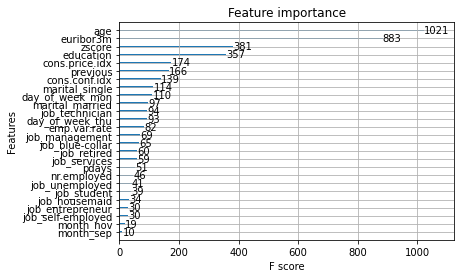

In [16]:
accuracy, f1 = xgboost_model(data_s)

In [ ]:
accuracy_dur, f1_dur = xgboost_model(data_s_dur)

As we can see, with the duration variable the results are considerably better.

### No duration model without lasts features in feature importance

In [ ]:
feat_score = pd.Series(model.get_booster().get_score(importance_type='weight'), index=model.get_booster().feature_names).sort_values(ascending=False)
feat_score.index[feat_score>100]

In [ ]:
X_train2 = X_train.loc[:, feat_score.index[feat_score>100]]
X_test2 = X_test.loc[:, feat_score.index[feat_score>100]]

In [ ]:
scores_list = []
metric = 'f1'
weight_array = np.arange(imbalance_rate - 7.5, imbalance_rate + 7.6, 0.5)
for weight in weight_array:
    model = xgb.XGBClassifier(scale_pos_weight=weight)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train2, y_train, scoring=metric, cv=cv, n_jobs=-1)
    print(f'Mean {metric}: %.5f' % np.mean(scores))
    scores_list.append(np.mean(scores))

In [ ]:
model = xgb.XGBClassifier(scale_pos_weight=weight_array[np.argmax(scores_list)])
model.fit(X_train2, y_train.astype(int))

In [ ]:
predictions = model.predict(X_test2)
accuracy = accuracy_score(y_test, predictions)

In [ ]:
(tn, fp, fn, tp) = confusion_matrix(y_train, model.predict(X_train2)).ravel()
(tn, fp, fn, tp)

In [ ]:
(tn, fp, fn, tp) = confusion_matrix(y_test, predictions).ravel()
(tn, fp, fn, tp)

# Decision tree

We want to preprune the tree to maximizes the f1 score

In [47]:
def post_prune(x_train, y_train):
    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(x_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    train_acc = []
    max_f1_score = 0
    best_c = 0
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(x_train, y_train)
        y_train_pred = clf.predict(x_train)
        f1 = f1_score(y_train_pred, y_train)
        if f1 > max_f1_score:
            max_f1_score = f1
            best_c = ccp_alpha        
    return best_c

In [56]:
def dt_model(data):
    X = data.loc[:, data.columns!= 'y_yes']
    y = data.loc[:, 'y_yes']
    
    rus = RandomUnderSampler(sampling_strategy=1)
    X_res, y_res = rus.fit_resample(X, y)
    
    x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)
    
    c = post_prune(x_train, y_train)
    print(c)
    
    metric = 'f1'
    
    params = {'max_depth': list(range(2, 10, 2)),
              'min_samples_split': list(range(2, 4)),
              'min_samples_leaf': [1, 2]}

    clf = DecisionTreeClassifier(ccp_alpha=c)
    gcv = GridSearchCV(estimator=clf, param_grid=params, scoring=metric)
    gcv.fit(x_train, y_train)
    
    dt = gcv.best_estimator_
    dt.fit(x_train,y_train)
    
    prediction = dt.predict(x_test)
    
    accuracy, f1 = model_metrics(dt, x_train, y_train, x_test, y_test, prediction)
    
    return accuracy, f1

In [57]:
dt_model(data)

5.075111652456355e-05
2727 555 931 2355
687 136 237 582


(0.7728380024360536, 0.7573194534808068)

In [58]:
dt_model(data_dur)

0.0
2867 424 202 3075
666 148 84 744


(0.8587088915956151, 0.8651162790697674)